# MCMC Comparison

## GPy

1. Train a GP (using GPy) to emulate the $S$-factor. 
2. Use that GP to calculate the $R$-matrix parameter posteriors.
3. Calculate the $R$-matrix parameter posteriors using the $R$-matrix prediction *directly*.

* range of energies

In [1]:
import os
import subprocess
from smt.sampling_methods import LHS

import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import seaborn as sns
from scipy import stats
import GPy
import emcee
import h5py

from dt import cross_section, s_factor

In [2]:
plt.style.use('science')
gr = (1 + np.sqrt(5)) / 2
h = 3

plt.rcParams['figure.dpi'] = 300

## Train the GP

In [3]:
# Other parameters that we are not trying to emulate yet.
AD = 6.0
AN = 4.0
UE = 0.0
A = 0.0
# Reduced mass in the deuteron channel.
MU_D = 1124.6473494927284 # MeV

# Our physics model.
def f(energy, theta):
    er, gd2, gn2 = theta
    return s_factor(energy, er, er, gd2, gn2, AD, AN, UE, A)

parameter_labels = [r'$E_r$', r'$\gamma_d^2$', r'$\gamma_n^2$']

In [4]:
train = np.loadtxt('datfiles/training_data.txt')
test = np.loadtxt('datfiles/testing_data.txt')

In [5]:
ns, nd = train.shape
nk = np.unique(train[:, 0]).size # number of momenta
ntrain = ns // nk
ntest = test.shape[0] // nk

In [6]:
def shift_and_scale(x):
    mean = np.mean(x, axis=0)
    sig = np.std(x, axis=0)
    return (x-mean)/sig, mean, sig

In [7]:
# X, Xmu, Xs = shift_and_scale(train[:, :4])
X = train[:, :4]
Y, Ymu, Ys = shift_and_scale(train[:, -1, np.newaxis])

# Xp = (test[:, :4] - Xmu) / Xs
Xp = test[:, :4]
Yp = (test[:, -1, np.newaxis] - Ymu) / Ys

In [68]:
kernel = GPy.kern.RBF(input_dim=1, active_dims=[1]) * \
         GPy.kern.RBF(input_dim=1, active_dims=[2]) * \
         GPy.kern.RBF(input_dim=1, active_dims=[3])

In [69]:
m = GPy.models.GPRegression(X, Y, kernel)

In [70]:
m.optimize()

In [71]:
print(m)


Name : GP regression
Objective : 6979.0581468524815
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  mul.rbf.variance         |   0.8511807002928053  |      +ve      |        
  mul.rbf.lengthscale      |  0.06078057201321385  |      +ve      |        
  mul.rbf_1.variance       |   0.8511807003030408  |      +ve      |        
  mul.rbf_1.lengthscale    |    8.381763532374915  |      +ve      |        
  mul.rbf_2.variance       |   0.8511807002984962  |      +ve      |        
  mul.rbf_2.lengthscale    |  0.22176374830220633  |      +ve      |        
  Gaussian_noise.variance  |   0.9434270778248723  |      +ve      |        


In [72]:
def residuals(y, mu, dy):
    return (y - mu) / dy

def relative_uncertainties(p):
    return (np.sqrt(p.var()) / p.mean())[0]

def absolute_uncertainties(p):
    return np.sqrt(p.var())[0]

In [73]:
mu, v = m.predict(X) # Let's check how the training went.

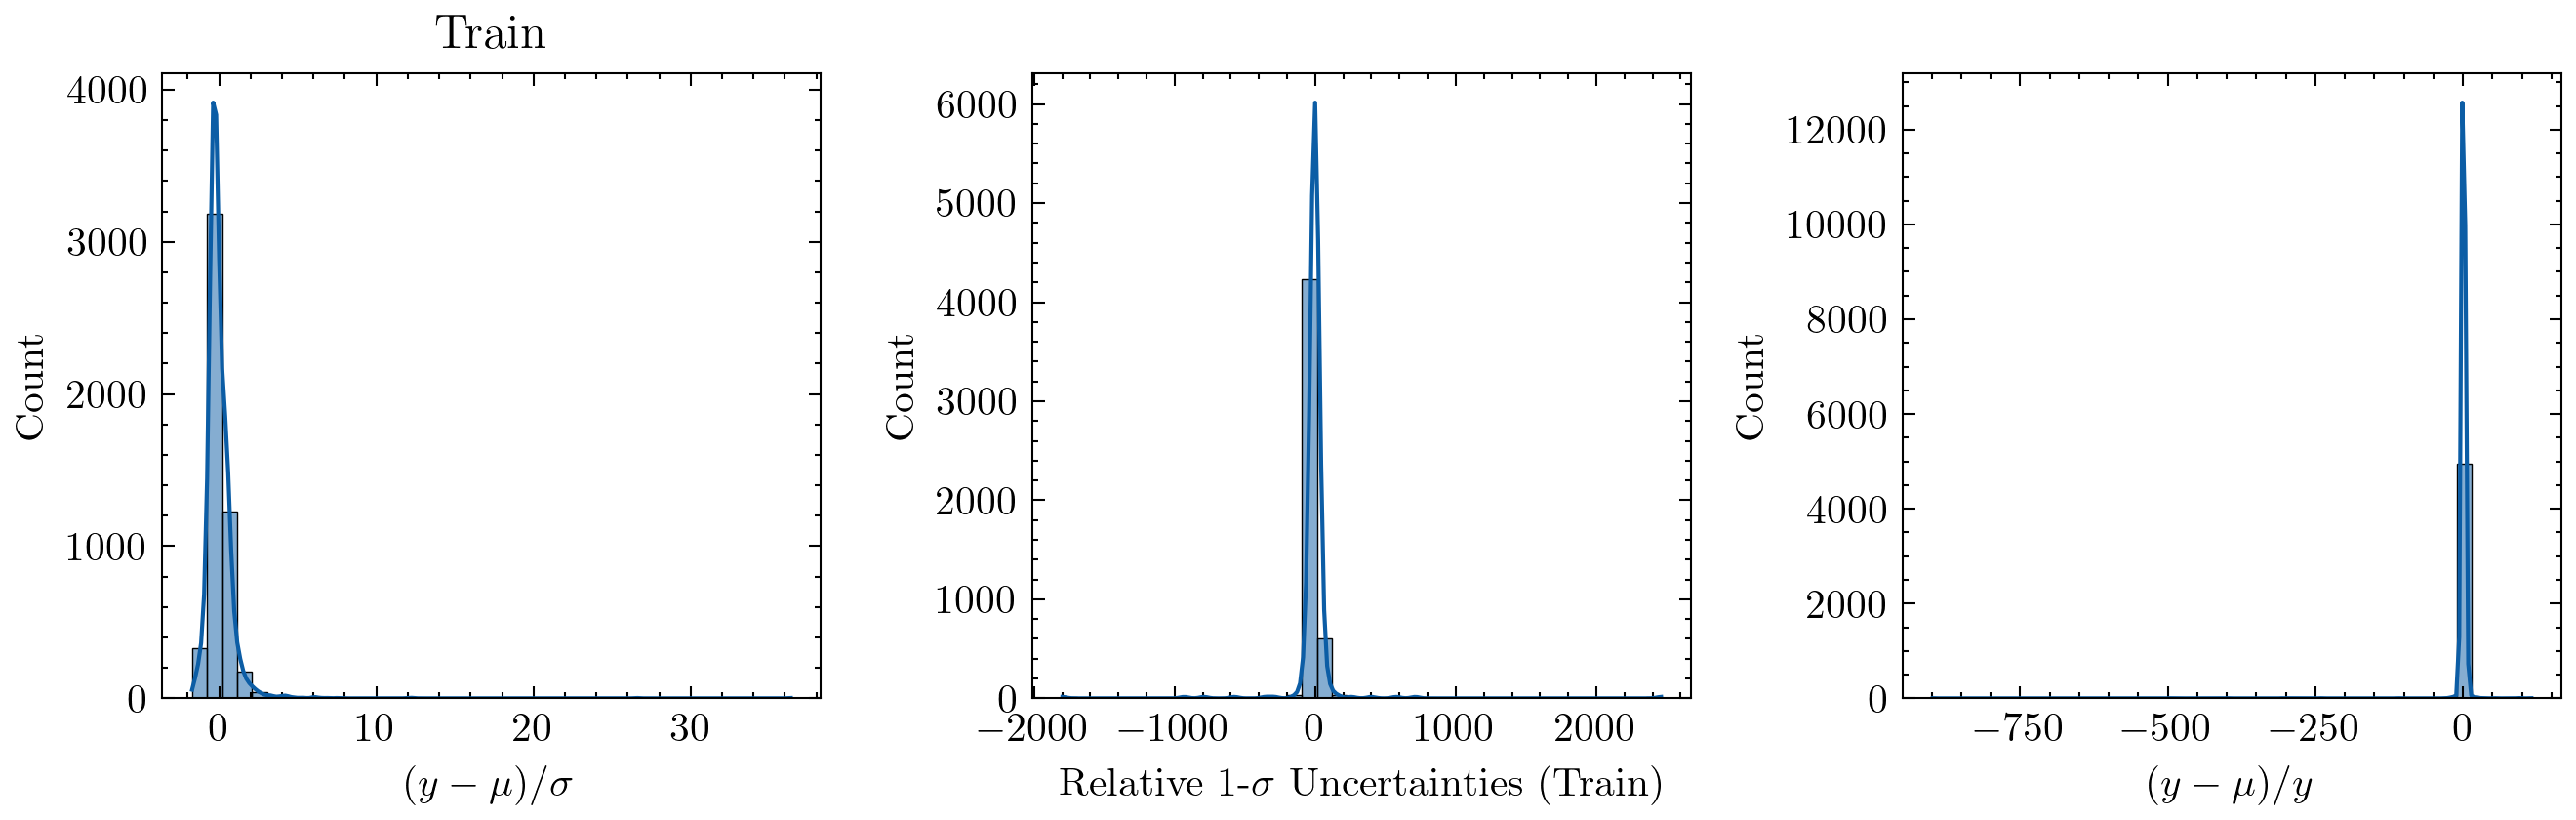

In [74]:
fig, ax = plt.subplots(ncols=3, figsize=(3*h, h), dpi=300)
fig.patch.set_facecolor('white')

sns.histplot(residuals(Y[:, 0], mu[:, 0], np.sqrt(v[:, 0])), bins=40, ax=ax[0], kde=True)
ax[0].set_xlabel(r'$(y-\mu)/\sigma$')
ax[0].set_title('Train')

sns.histplot(np.sqrt(v[:, 0])/mu[:, 0], bins=40, ax=ax[1], kde=True) 
ax[1].set_xlabel(r'Relative 1-$\sigma$ Uncertainties (Train)')

sns.histplot(((Y[:, 0] - mu[:, 0]) / Y[:, 0]), bins=40, ax=ax[2], kde=True) 
ax[2].set_xlabel(r'$(y-\mu)/y$')

plt.tight_layout();

In [75]:
mup, vp = m.predict(Xp) # Let's check how the training went.

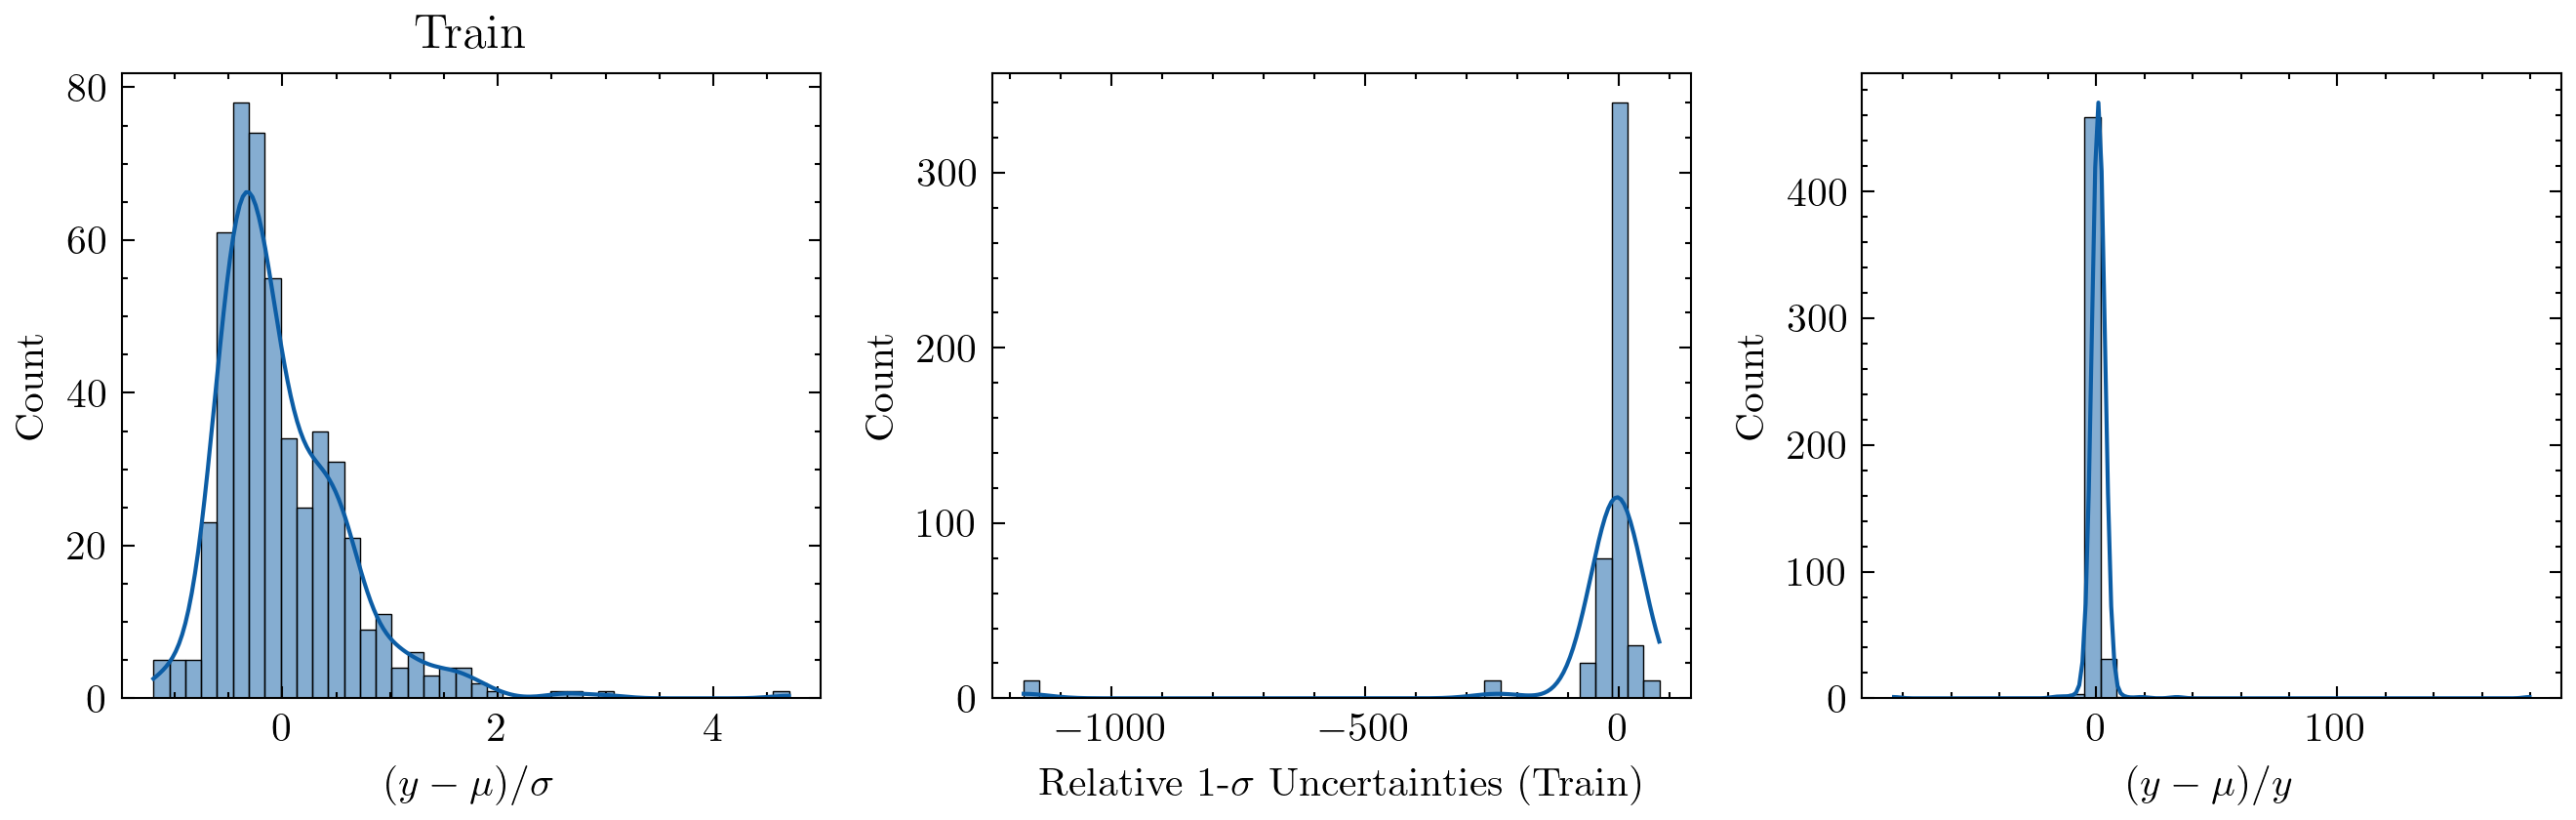

In [76]:
fig, ax = plt.subplots(ncols=3, figsize=(3*h, h), dpi=300)
fig.patch.set_facecolor('white')

sns.histplot(residuals(Yp[:, 0], mup[:, 0], np.sqrt(vp[:, 0])), bins=40, ax=ax[0], kde=True)
ax[0].set_xlabel(r'$(y-\mu)/\sigma$')
ax[0].set_title('Train')

sns.histplot(np.sqrt(vp[:, 0])/mup[:, 0], bins=40, ax=ax[1], kde=True) 
ax[1].set_xlabel(r'Relative 1-$\sigma$ Uncertainties (Train)')

sns.histplot(((Yp[:, 0] - mup[:, 0]) / Yp[:, 0]), bins=40, ax=ax[2], kde=True) 
ax[2].set_xlabel(r'$(y-\mu)/y$')

plt.tight_layout();

In [77]:
bounds = [[np.min(x), np.max(x)] for x in X[:, 1:4].T]

In [78]:
momenta = np.unique(train[:, 0])
energies = momenta**2 / (2*MU_D)
THETA_TRUE = np.array([0.040, 2.5, 0.1])
DATA = np.array([f(ei, THETA_TRUE) for ei in energies])
DATA_ERR = 0.01 * DATA


priors = [stats.uniform(b[0], b[1]-b[0]) for b in bounds]

def ln_prior(theta):
    return np.sum([p.logpdf(t) for (p, t) in zip(priors, theta)])

In [79]:
class Model:
    def __init__(self, predict):
        self.predict_func = predict
    
    
    def ln_likelihood(self, theta):
        mu, var = self.predict_func(theta)
        var_tot = DATA_ERR**2 + var
        return np.sum(-np.log(np.sqrt(2*np.pi*var_tot)) - (DATA - mu)**2 / var_tot)


    def ln_posterior(self, theta):
        lnpi = ln_prior(theta)
        if lnpi == -np.inf:
            return -np.inf
        return lnpi + self.ln_likelihood(theta)

In [80]:
ntrain, X.shape

(500, (5000, 4))

In [82]:
def gp_func(theta):
    x = np.array([[en, *theta] for en in energies])
    mu, v = m.predict(x)
    return mu.flatten(), v.flatten()


def r_func(theta):
    return np.array([f(ei, theta) for ei in energies]), np.zeros(energies.size)


model_gp = Model(gp_func)
model_r = Model(r_func)

In [83]:
nd = 3
nw = 2*nd

In [84]:
p0 = np.array(
    [stats.norm(THETA_TRUE, 0.01*np.abs(THETA_TRUE)).rvs() for _ in range(nw)]
)

In [85]:
moves = [(emcee.moves.DEMove(), 0.2), (emcee.moves.DESnookerMove(), 0.8)]
sampler_gp = emcee.EnsembleSampler(nw, nd, model_gp.ln_posterior, moves=moves)
sampler_r = emcee.EnsembleSampler(nw, nd, model_r.ln_posterior, moves=moves)

In [86]:
state = sampler_gp.run_mcmc(p0, 1000, thin_by=10, tune=True, progress=True)

100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [19:32<00:00,  8.53it/s]


In [87]:
state = sampler_r.run_mcmc(p0, 1000, thin_by=10, tune=True, progress=True)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 855.54it/s]


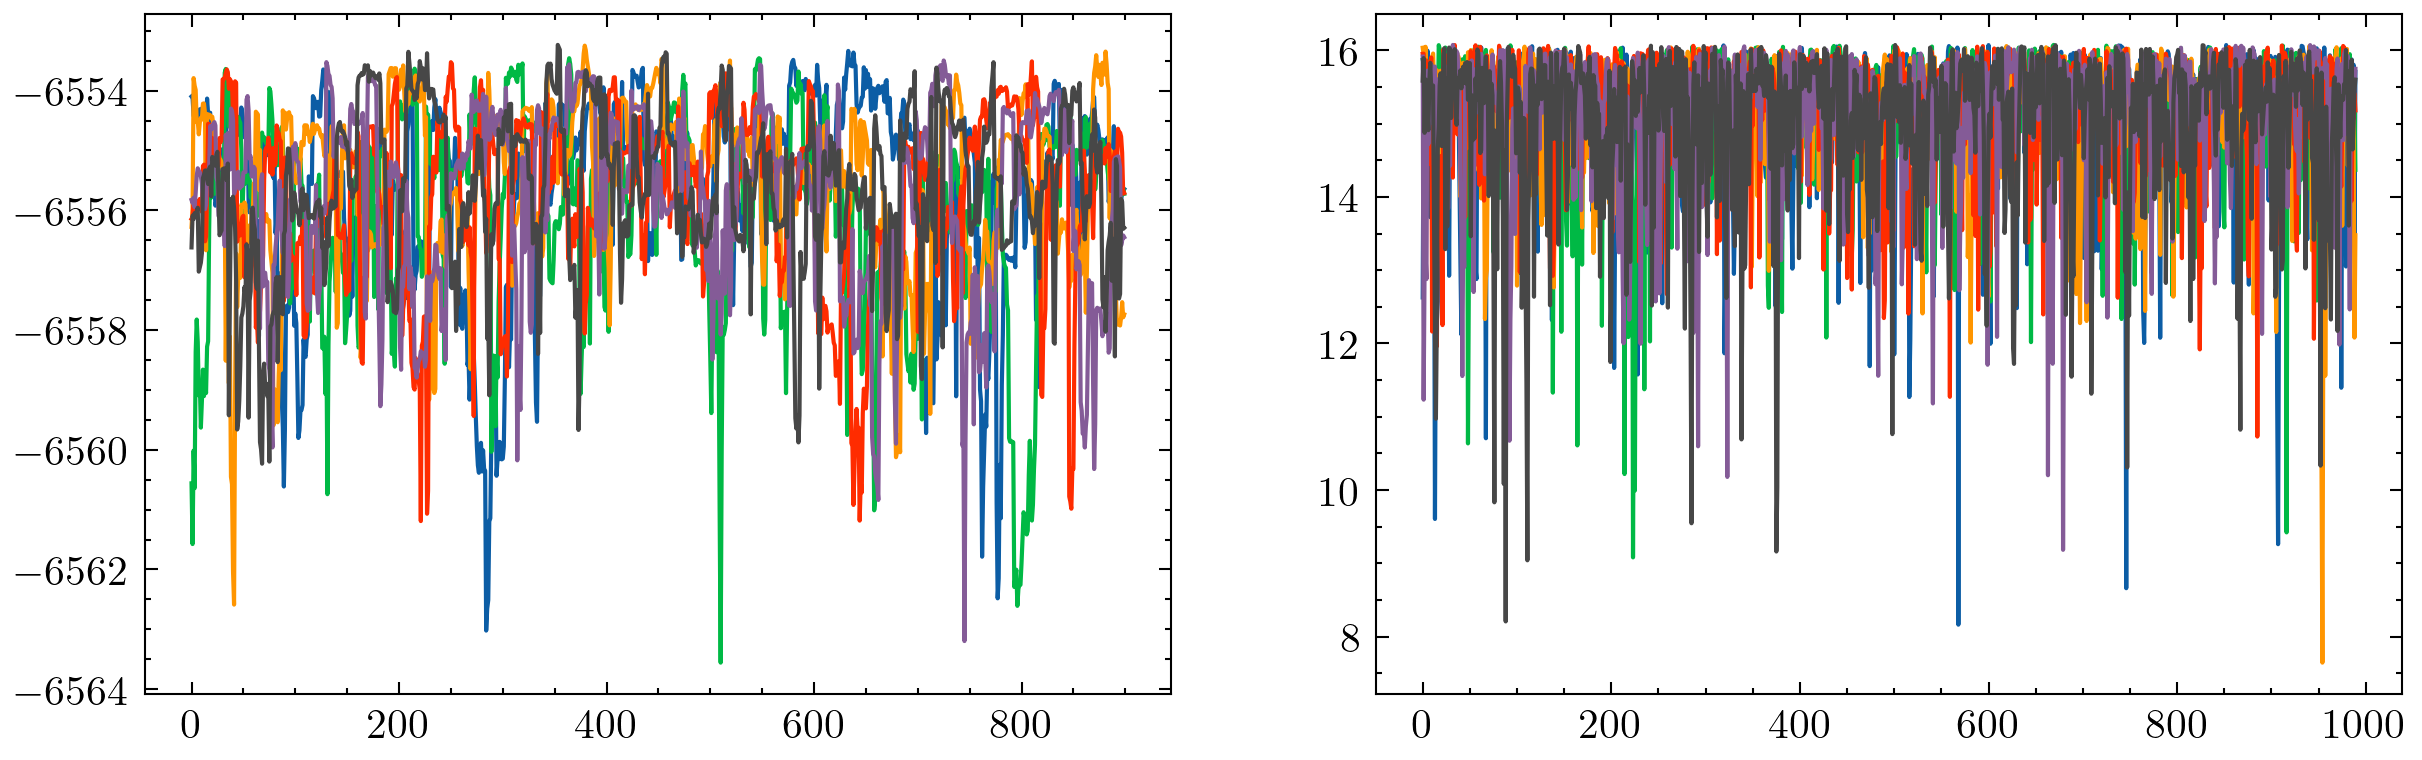

In [90]:
fig, ax = plt.subplots(ncols=2, figsize=(2*gr*h, h))
fig.patch.set_facecolor('white')

ax[0].plot(sampler_gp.get_log_prob(discard=100))
ax[1].plot(sampler_r.get_log_prob(discard=10));

In [92]:
flat_chain_gp = sampler_gp.get_chain(flat=True, discard=100)
flat_chain_r = sampler_r.get_chain(flat=True, discard=10)

In [93]:
from corner import corner

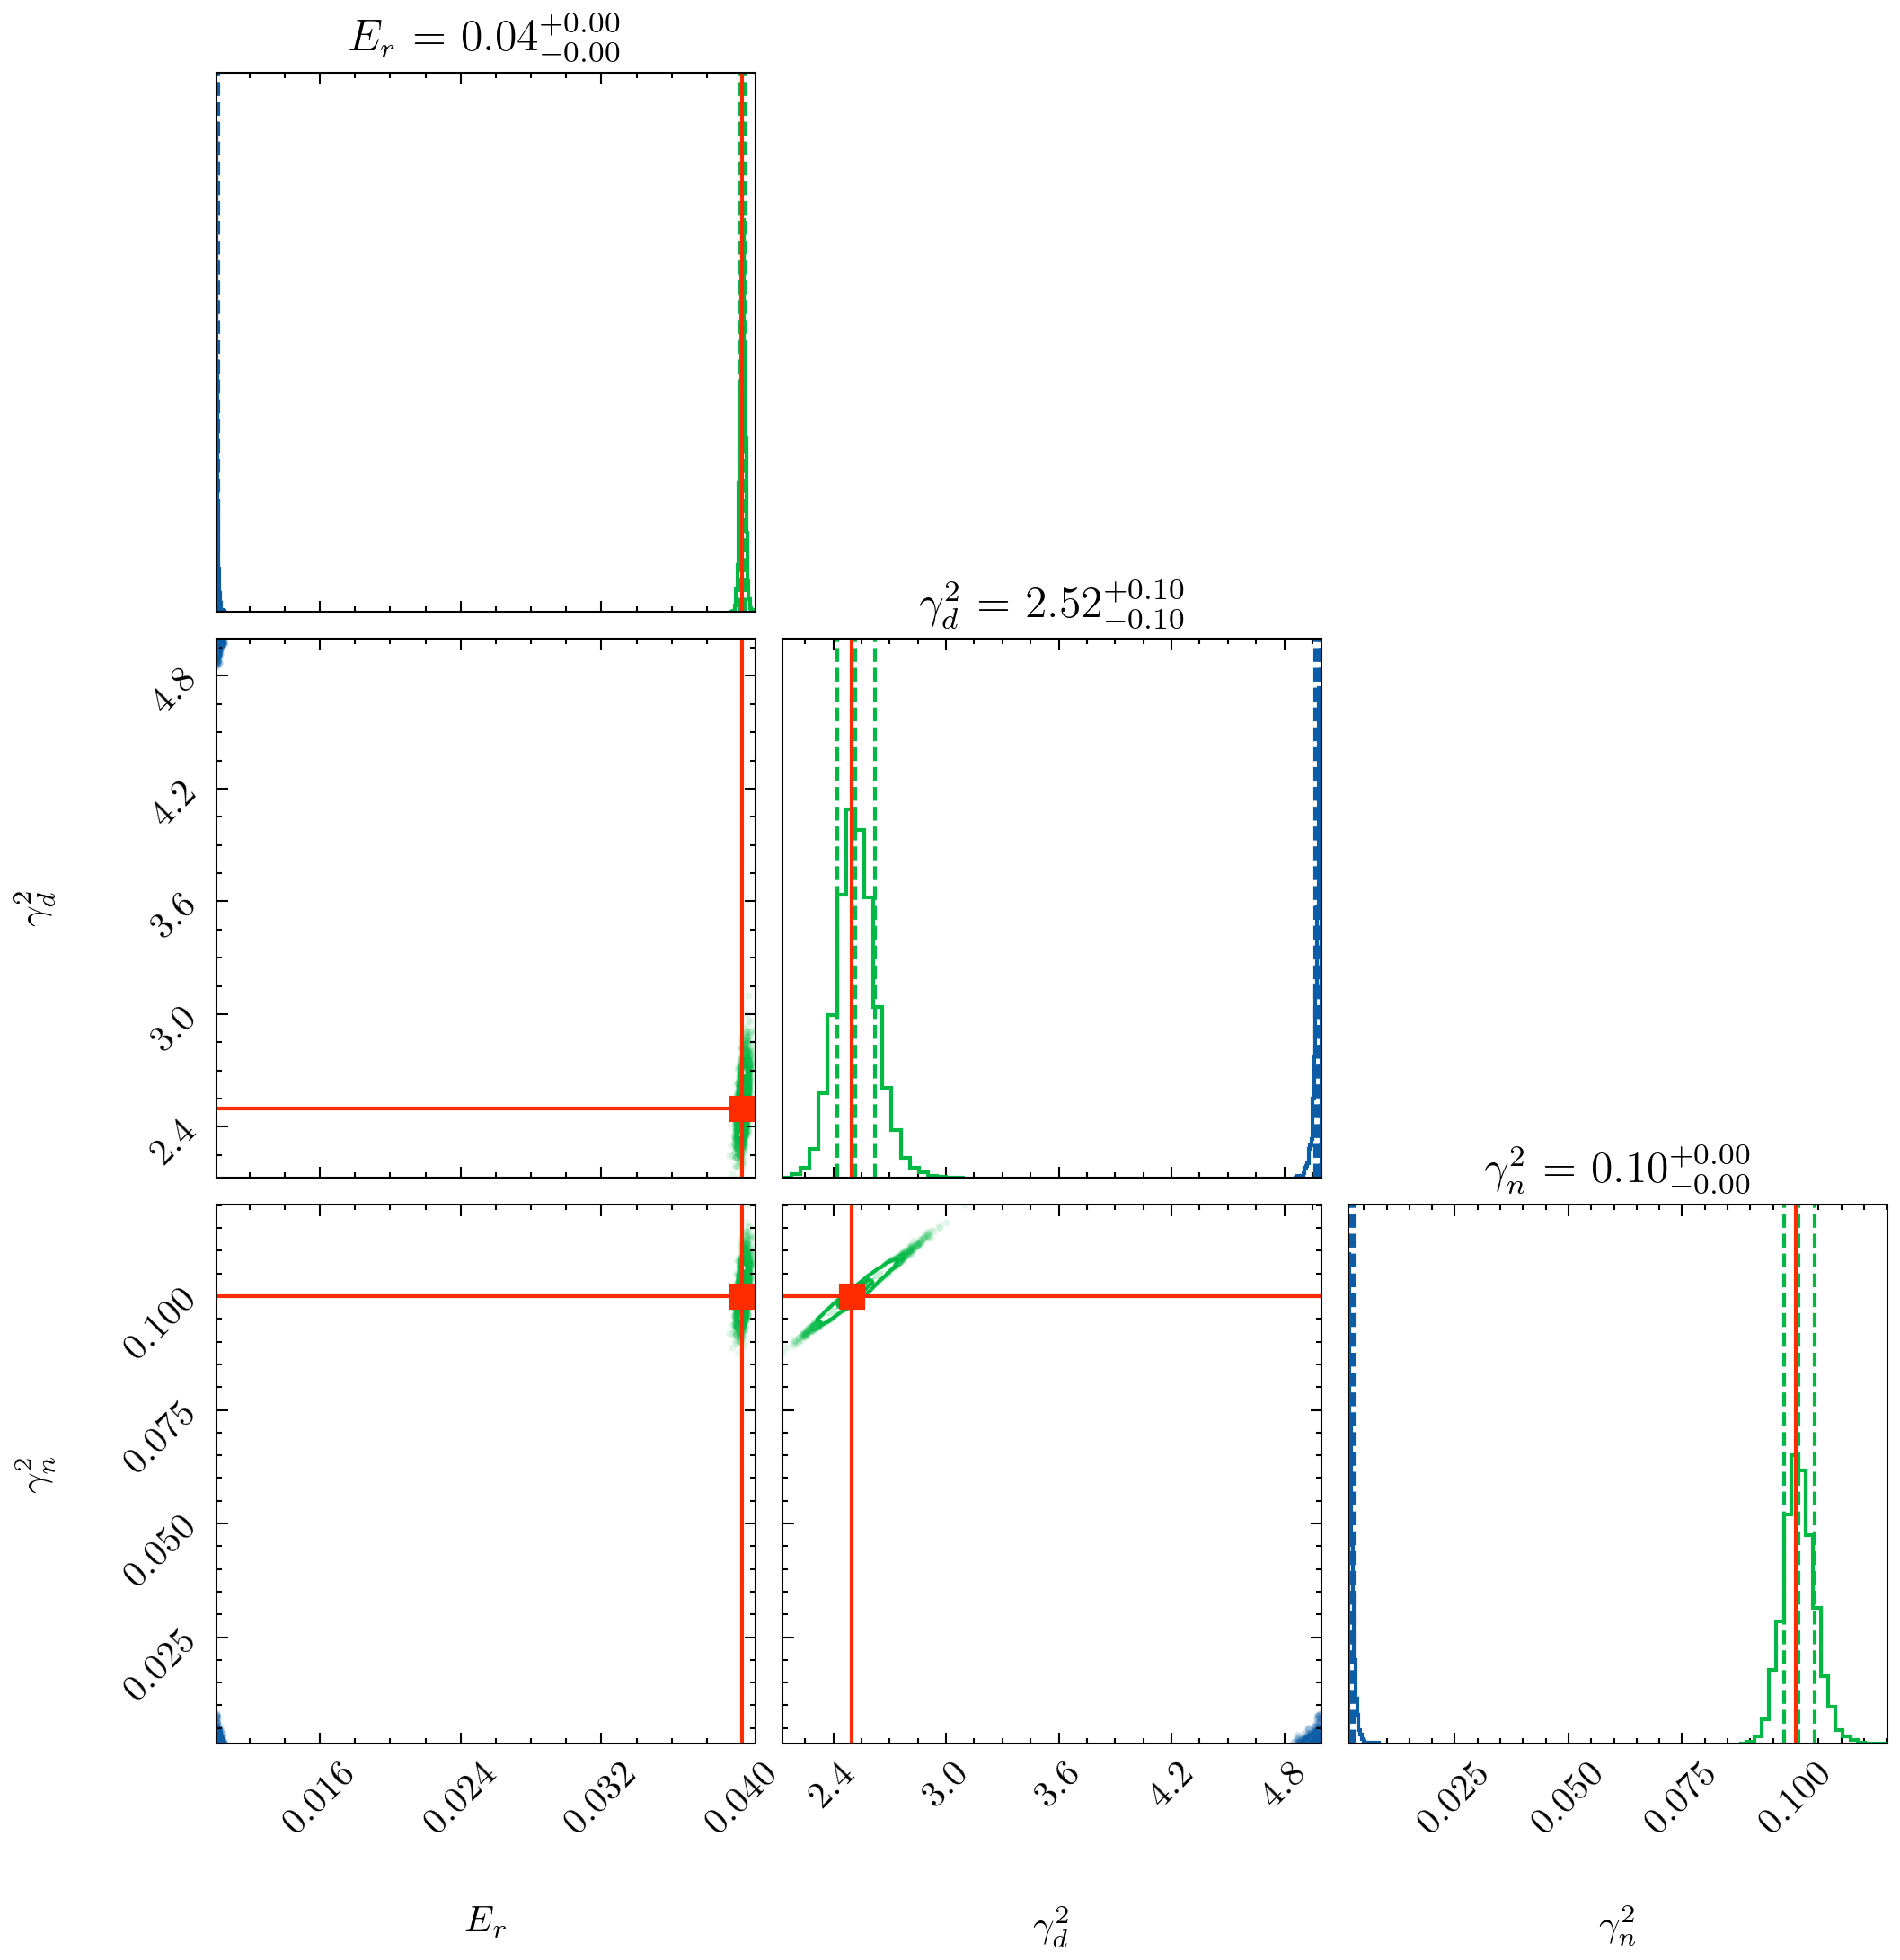

In [94]:
fig = corner(flat_chain_gp, labels=parameter_labels, show_titles=True, quantiles=[0.16, 0.5, 0.84], color='C0')
fig = corner(flat_chain_r, color='C1', labels=parameter_labels, show_titles=True,
             quantiles=[0.16, 0.5, 0.84], fig=fig, truths=THETA_TRUE, truth_color='C3')
fig.patch.set_facecolor('white')

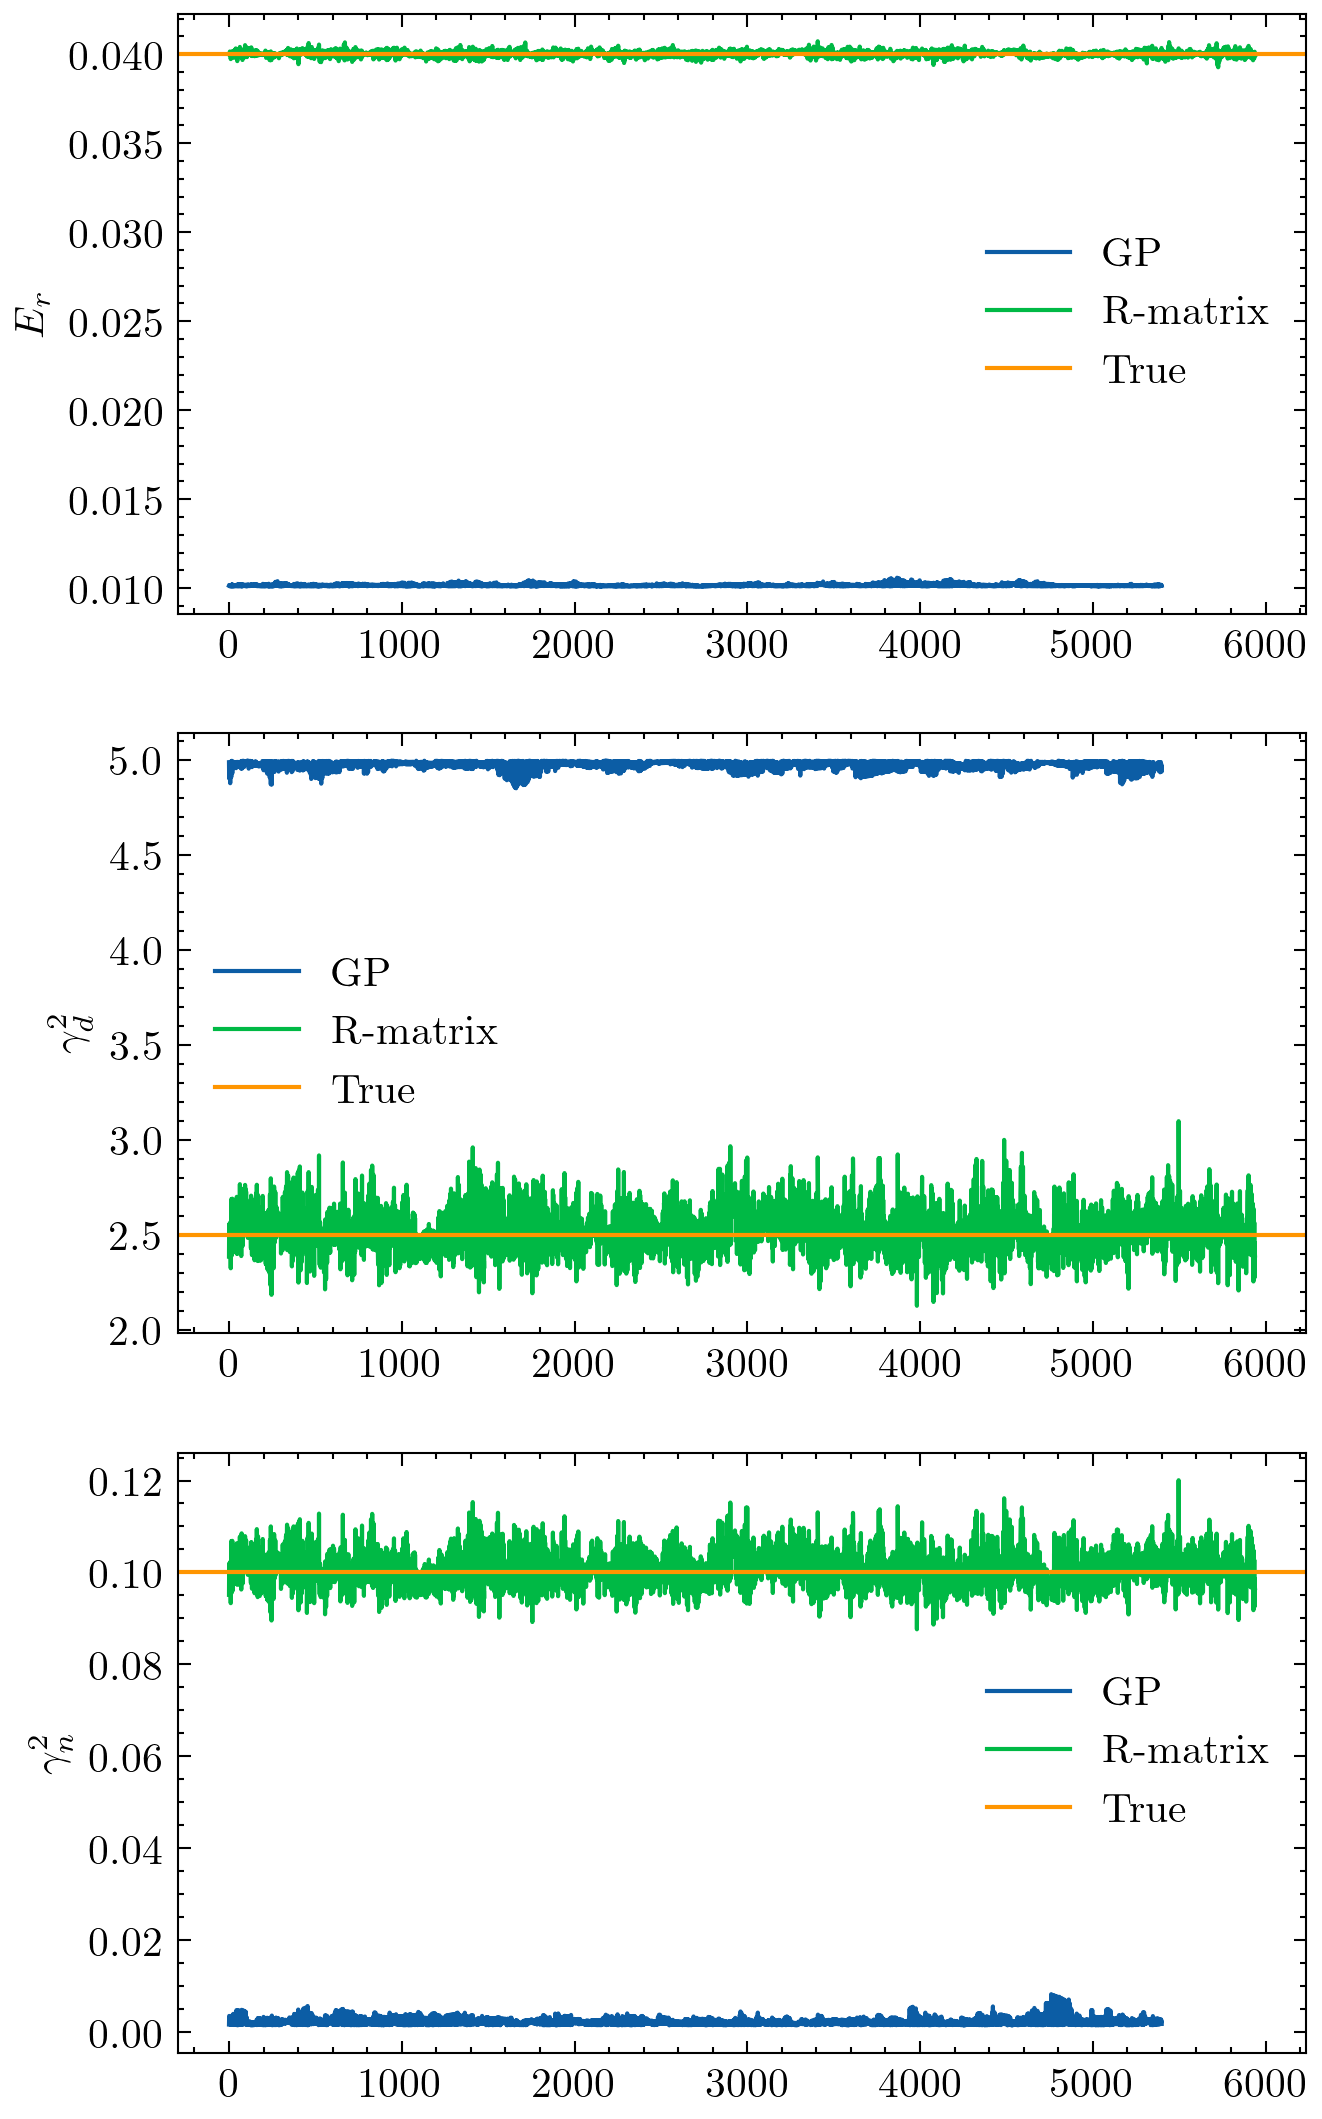

In [95]:
fig, ax = plt.subplots(3, figsize=(gr*h, 3*h))
fig.patch.set_facecolor('white')

for i in range(3):
    ax[i].plot(flat_chain_gp[:, i], label='GP')
    ax[i].plot(flat_chain_r[:, i], label='R-matrix')
    ax[i].set_ylabel(parameter_labels[i])
    ax[i].axhline(THETA_TRUE[i], color='C2', label='True')
    ax[i].legend()